# Projeto de Extensão 2 - Análise de outliers em medições de um Sensor de vazão

### Bibliotecas utilizadas

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

## Carregamento e preparação dos dados

In [ ]:
file_path = "medicoes.txt"

# Formato: DATA LITROS L TEMPO
df = pd.read_csv(
    file_path,
    header=None,
    names=["data", "litros_str", "tempo_str"],
    delim_whitespace=True
)

# Remove o "L" do final e converte para float
df["litros"] = df["litros_str"].str.replace("L", "", regex=False).astype(float)

# Converte data (dd/mm/yyyy) e tempo (HH:MM:SS)
df["data"] = pd.to_datetime(df["data"], format="%d/%m/%Y")
df["tempo"] = pd.to_timedelta(df["tempo_str"])

# Duração em minutos
df["duracao_min"] = df["tempo"].dt.total_seconds() / 60.0

# Só por segurança, descarta qualquer coisa com tempo zero ou negativo
df = df[df["duracao_min"] > 0].copy()

/tmp/ipython-input-3923045611.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


## Regressão litros x duração + cálculo de resíduos

In [ ]:
# X = duração em minutos, y = litros
X_reg = df[["duracao_min"]].values
y_reg = df["litros"].values

modelo = LinearRegression()
modelo.fit(X_reg, y_reg)

# Predição pela reta
df["litros_pred"] = modelo.predict(X_reg)

# Resíduo = diferença entre medido e previsto
df["residuo"] = df["litros"] - df["litros_pred"]
df["abs_residuo"] = df["residuo"].abs()

# Limiar para definir outlier: aqui uso o percentil 90 dos desvios
# (você pode mudar para 0.95 se quiser ser mais rígido)
thr_abs_res = df["abs_residuo"].quantile(0.90)

df["is_outlier"] = df["abs_residuo"] > thr_abs_res

print("Coeficientes da reta (litros = a * duração + b):")
print(f"  a = {modelo.coef_[0]:.3f} L/min")
print(f"  b = {modelo.intercept_:.3f} L")
print(f"Limiar de outlier (|resíduo| > {thr_abs_res:.2f} L)\n")

print("Quantidade de outliers detectados:", df["is_outlier"].sum(), "\n")

Coeficientes da reta (litros = a * duração + b):
  a = 21.435 L/min
  b = 5.056 L
Limiar de outlier (|resíduo| > 75.13 L)

Quantidade de outliers detectados: 18 



## Alerta de outliers

In [ ]:
print("==== ALERTAS DE OUTLIER (baseados na reta tempo × litros) ====\n")

outliers = df[df["is_outlier"]].sort_values("abs_residuo", ascending=False)

for _, row in outliers.iterrows():
    dia     = row["data"].strftime("%d/%m/%Y")
    duracao = row["tempo_str"]
    litros  = row["litros"]

    print(f"[ALERTA] Dia: {dia} | Duração: {duracao} | Litros: {litros:.2f} L")

==== ALERTAS DE OUTLIER (baseados na reta tempo × litros) ====

[ALERTA] Dia: 08/08/2025 | Duração: 00:44:00 | Litros: 2889.27 L
[ALERTA] Dia: 13/09/2025 | Duração: 00:37:00 | Litros: 2504.79 L
[ALERTA] Dia: 21/06/2025 | Duração: 00:44:00 | Litros: 29.53 L
[ALERTA] Dia: 04/11/2025 | Duração: 00:43:00 | Litros: 29.59 L
[ALERTA] Dia: 04/08/2025 | Duração: 00:42:00 | Litros: 21.32 L
[ALERTA] Dia: 14/09/2025 | Duração: 00:37:00 | Litros: 10.05 L
[ALERTA] Dia: 25/10/2025 | Duração: 00:34:00 | Litros: 19.25 L
[ALERTA] Dia: 03/10/2025 | Duração: 00:13:00 | Litros: 981.37 L
[ALERTA] Dia: 05/06/2025 | Duração: 00:27:00 | Litros: 21.28 L
[ALERTA] Dia: 05/07/2025 | Duração: 00:13:00 | Litros: 749.10 L
[ALERTA] Dia: 20/08/2025 | Duração: 00:13:00 | Litros: 5.09 L
[ALERTA] Dia: 09/11/2025 | Duração: 00:51:00 | Litros: 972.41 L
[ALERTA] Dia: 10/11/2025 | Duração: 00:51:00 | Litros: 991.03 L
[ALERTA] Dia: 31/05/2025 | Duração: 00:22:00 | Litros: 370.03 L
[ALERTA] Dia: 16/09/2025 | Duração: 00:38:00 |

## Plots

### Litros ao longo do tempo, marcando outliers

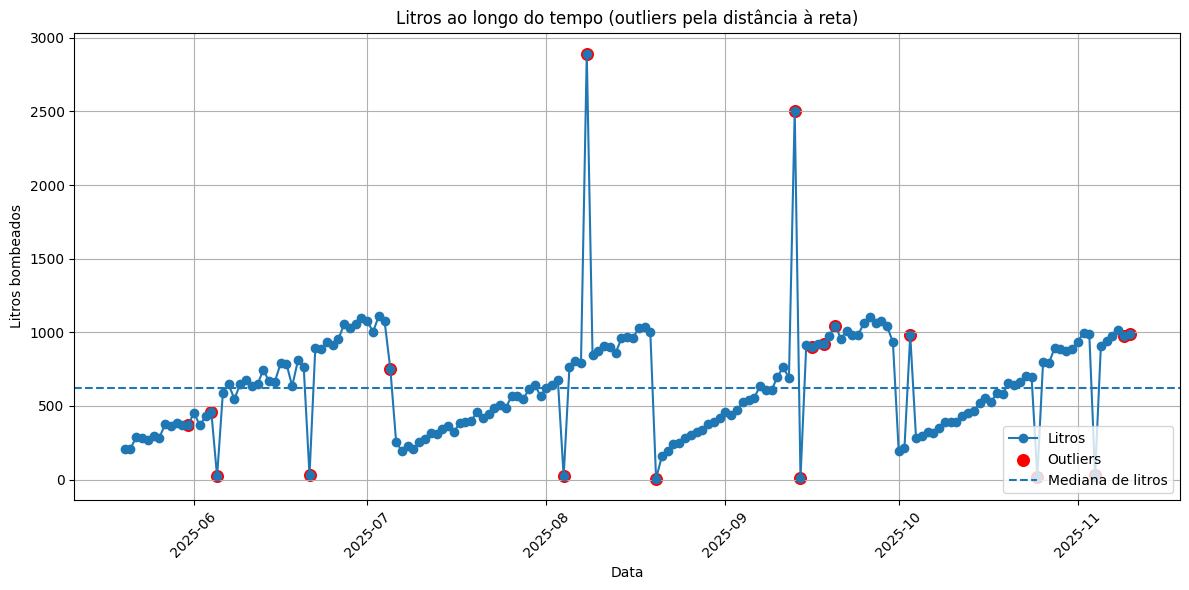

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df["data"], df["litros"], marker="o", linestyle="-", label="Litros")

plt.scatter(outliers["data"], outliers["litros"],
            s=70, c="red", label="Outliers")

plt.axhline(df["litros"].median(), linestyle="--", label="Mediana de litros")
plt.xlabel("Data")
plt.ylabel("Litros bombeados")
plt.title("Litros ao longo do tempo (outliers pela distância à reta)")
plt.grid(True)
plt.legend(loc="lower right")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Relação litros x duração com reta de regressão e outliers

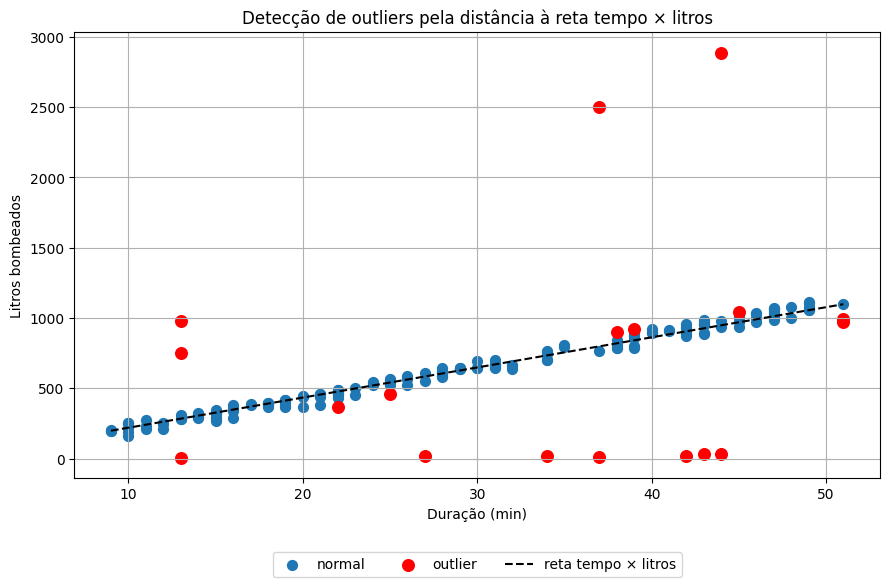

In [ ]:
plt.figure(figsize=(9, 6))

normais = df[~df["is_outlier"]]

# pontos normais
plt.scatter(normais["duracao_min"], normais["litros"],
            c="tab:blue", s=50, label="normal")

# outliers em vermelho
plt.scatter(outliers["duracao_min"], outliers["litros"],
            c="red", s=70, label="outlier")

# reta de regressão
x_line = np.linspace(df["duracao_min"].min(), df["duracao_min"].max(), 100)
y_line = modelo.predict(x_line.reshape(-1, 1))
plt.plot(x_line, y_line, color="black", linestyle="--", label="reta tempo × litros")

plt.xlabel("Duração (min)")
plt.ylabel("Litros bombeados")
plt.title("Detecção de outliers pela distância à reta tempo × litros")
plt.grid(True)

# legenda horizontal fora do plot (embaixo)
plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),  # desloca para fora do gráfico
    ncol=3                        # tudo em uma linha
)

plt.tight_layout()
plt.show()
